# Proteome trajectories of insulin-sensitive and -resistant individuals 

## Setup
Let’s begin by importing the modules we’ll need.

In [9]:
import sys 
sys.path.append('/home/labs/elinav/uria/mprod_package/')

import pandas as pd
import numpy as np

from mprod.dimensionality_reduction import TCAM
from mprod import table2tensor

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import scipy

import random
from multiprocessing import Pool
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from itertools import combinations

import matplotlib as mpl

%matplotlib inline



### PERMANOVA and prunning utils

In [2]:
def pairwise_melt_meta(meta, data):
    _dm = pairwise_distances(data.loc[meta['Participant']])
    for i in range(_dm.shape[0]):
        _dm[i,i:] = None
    _dm_df = pd.DataFrame(_dm, index = meta['Participant'].rename('sample1'), columns=meta['Participant'].rename('sample2'))

    _dm_melt = pd.melt(_dm_df.reset_index(), id_vars=['sample1'], value_name='d').dropna()

    metacols = ['rGroup','Participant']
    _dm_melt2 = meta.loc[:, metacols].merge(_dm_melt, right_on = 'sample2', left_on = 'Participant', how = 'right')#.drop('SampleID', axis=1)
    _dm_melt_meta = meta.loc[:, metacols].merge(_dm_melt2, right_on = 'sample1', left_on= 'Participant', how = 'right', suffixes = ("1","2"))#.drop('SampleID', axis=1)
    return _dm_melt_meta

def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)


def ss_total(data):
    return (data['d']**2).sum()

def ss_within(data):
    if 'rGroup11' in data.columns:
        return data.query('rGroup11 == rGroup22').groupby('rGroup11')['d'].apply(lambda x: (x**2).sum()).sum()
    else:
        return data.query('rGroup1 == rGroup2').groupby('rGroup1')['d'].apply(lambda x: (x**2).sum()).sum()

def ss_between(data, ss_t):
    return ss_t - ss_within(data)

def Fstat(data, ss_t = None, N = None):
    if N is None:
        N = len(set(data['sample1'].tolist() + data['sample2'].tolist()))
    if ss_t is None:
        ss_t = ss_total(data)
    ss_w = ss_within(data)
    ss_b = ss_t - ss_w
    return ss_b / (ss_w / (N - 2))


def gen_rperm(meta, r):
    _mice_map = meta.loc[:, ['Participant', 'rGroup']].copy()
    _mice_map.drop_duplicates(inplace=True)
    _mice_map.index = _mice_map['Participant']
    gsizes = _mice_map.groupby('rGroup').size()
    g1size, g1label, g2label = gsizes[0], gsizes.index[0], gsizes.index[-1]


    for combo in  random_combination(combinations(_mice_map.index, g1size), r):
        _mice_map['Group_perm'] = g2label
        _mice_map.loc[combo ,'Group_perm'] = g1label
        yield _mice_map['Group_perm'].to_dict()

def _permfs(args):
    __data, tv, N, permdict = args
    _data = __data.copy()
    _data['rGroup11'] = _data['Participant1'].map(permdict)
    _data['rGroup22'] = _data['Participant2'].map(permdict)
    return Fstat(_data, tv, N)


def run_permanova(meta, data, nperms = 1000):
    _dmm = pairwise_melt_meta(meta, data)

    _dmm['rGroup11'] = _dmm['rGroup1'].copy()
    _dmm['rGroup22'] = _dmm['rGroup2'].copy()

    N = len(set(_dmm['sample1'].tolist() + _dmm['sample2'].tolist()))
    total_var = ss_total(_dmm)
    fs_obs = Fstat(_dmm, total_var, N)

    
    with Pool(processes=15) as p:
        fs_perms = p.imap(_permfs, ((_dmm, total_var, N, dd) for dd in gen_rperm(meta, nperms)))
        fs_perms = np.array([x for x in fs_perms])

        
    return ((fs_perms > fs_obs).sum() + 1) / (nperms + 1)


def get_truncated_factors(transformer, criterion = 'n_factors', threshold = -1):
    assert criterion in ['n_factors', 'min_total_var','min_var','gap']
    
    if criterion == 'min_total_var':
        n_factors = np.argmax(transformer.explained_variance_ratio_.cumsum() > threshold) + 1
    elif criterion == 'min_var':
        n_factors = np.argmin(transformer.explained_variance_ratio_ > threshold)
    elif criterion == 'gap':
        n_factors = np.argmin((-np.diff(transformer.explained_variance_ratio_)) > threshold)
    else:
        n_factors = transformer.explained_variance_ratio_.size if threshold == -1 else threshold
    
    n_factors = max(n_factors, 1)
    return n_factors

def prune_factors(transformed_data, row_factors, transformer, criterion = 'n_factors', threshold = -1 ):
    mwt_aov = transformed_data.copy()
    mwt_aov.columns = np.arange(0,mwt_aov.columns.size)
    
    def apply_f(x):
        return pd.Series(scipy.stats.f_oneway(*[x.loc[v] for k,v in row_factors.items()])
                         , index = ['F', 'P(>F)'])
    
    n_factors = get_truncated_factors(transformer, criterion, threshold )
    
    fres = (mwt_aov.iloc[:,:n_factors] ).apply(apply_f).T.sort_values('P(>F)')
    fres['q'] = multipletests(fres['P(>F)'].values, method = 'fdr_bh')[1]
    return fres.sort_values('q')

### Data transformation functions

In [3]:
class DataframeTransformer(TransformerMixin):
    def __init__(self, transformer):
        self.transformer = transformer

    def transform(self,X,y=None, **transform_params):
        Xcp = X.copy()
        return pd.DataFrame(self.transformer.transform(Xcp), index = X.index, columns= X.columns)

    def fit(self, X, y=None, **fit_params):
        self.transformer = self.transformer.fit(X.values)
        return self


class IndexMuncher(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X,y=None, modemap = []):
        return self
    
    def transform(self, X, y = None):
        datacols = X.columns.tolist()
        blmean = X.copy()
        blmean['time_index'] = blmean.index.get_level_values('y') * 4 + blmean.index.get_level_values('T')-1
        blmean = blmean.reset_index(level = ['SubjectID']).groupby(['SubjectID','time_index'])[datacols].apply(lambda x:x.iloc[0,:])
        return blmean

    def fit_transform(self, X, y = None, modemap = []):
        self = self.fit(X, y, modemap)
        Xt = self.transform(X, y)
        modemap += Xt.index.to_list()
        return Xt

    
def blmean_dataframe(X, y = None):
    blmean = X.groupby(level=['SubjectID']).apply(lambda x:x - x.loc[x.index.get_level_values('y') <=0 ].median())
    return blmean

blmean_dataframe_funtrans = FunctionTransformer(blmean_dataframe)

def df_capper(X,y=None):
    param = 1.5
    Xt= X.copy()
    Xt[Xt > param] = param
    Xt[Xt < -param] = -param
    return Xt


## Dataset

This study <a id="1">[1]</a> had a unique longitudinal experimental setting of healthy volunteers, with approximately 12 samples taken from each participant during the time course of three years, with a comprehensive metadata collection. Instead of addressing circadian seasonal patterns, which were the main focus of the original work, we addressed the differences between proteome trajectories of IR and the IS groups throughout the three years. 

In [4]:
pr_interp_data = pd.read_csv("./Sailani2020.txt", sep = "\t", index_col=[0,1,2])
idmapper = {a:b for a,b in zip(pr_interp_data.index.get_level_values('SubjectID').values,pd.factorize(pr_interp_data.index.get_level_values('SubjectID').values)[0])}

pr_interp_data.rename(mapper = idmapper, axis=0, level='SubjectID', inplace = True)


preproc = Pipeline([('ss1', DataframeTransformer(StandardScaler(with_std=True))),
                    ('cap', DataframeTransformer(FunctionTransformer(df_capper))),
                    ('blmean', blmean_dataframe_funtrans),
                    ('ss2', DataframeTransformer(StandardScaler(with_std=True))),
                    ('index_transform', IndexMuncher())
                   ])
munged_blmean_data = preproc.fit_transform(pr_interp_data)

pr_tensor, mode1_mapping, mode3_map = table2tensor(munged_blmean_data)
mode1_reverse_map = {val:k for k,val in mode1_mapping.items()}
mwt_obj = TCAM()

pr_mwt = mwt_obj.fit_transform(pr_tensor)
pr_load = mwt_obj.mode2_loadings

mwt_trans = pd.DataFrame(pr_mwt)
mwt_trans.index = mwt_trans.index.map(mode1_mapping)
mwt_trans.columns = ['F_${'+str(i)+'}$:'+ f'{np.round(100*v,2)}%' for i,v in enumerate(mwt_obj.explained_variance_ratio_[:mwt_obj.n_components],start = 1)]


pr_mwt_load = pd.DataFrame(pr_load, columns=mwt_trans.columns, index = munged_blmean_data.columns)



### Scatterplot of leading tcam factors significantly correlated with SSPG.

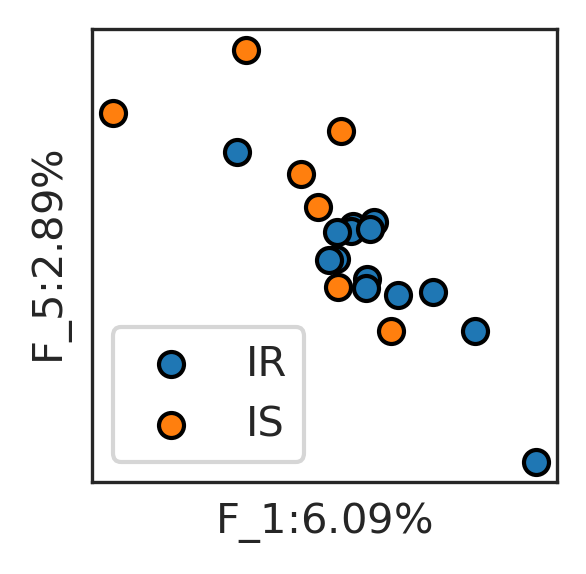

# factors for permanova  6
permanova p: 0.07892107892107893
F_${1}$:6.09% Ttest_indResult(statistic=2.3169139440183177, pvalue=0.03182852744235095)
F_${5}$:2.89% Ttest_indResult(statistic=-2.231517750094683, pvalue=0.03788850745795959)


In [8]:
meta_general = pd.read_csv("./metadata_Sailani2020.txt", sep = "\t")
meta_general['SubjectID'] = meta_general['SubjectID'].map(idmapper)
meta_general = meta_general.dropna(subset = ['SubjectID'])
meta_general['SubjectID'] = meta_general['SubjectID'].astype(int)
meta_mwt = meta_general.loc[meta_general['SubjectID'].isin(list(mode1_mapping.values()))].copy().drop_duplicates()
meta_mwt_trans = meta_mwt.merge(mwt_trans, left_on = 'SubjectID', right_index=True)

corr_df = meta_mwt_trans.loc[:,['SSPG'] + mwt_trans.columns[:10].tolist()].copy()
corr_values = corr_df.corr(method = 'pearson').iloc[:,:1].iloc[1:,0].abs().sort_values(ascending = False)

corr_df = meta_mwt_trans.loc[:,['SSPG'] + mwt_trans.columns[:10].tolist()].copy()
corr_values = corr_df.corr(method = 'pearson').iloc[:,:1].iloc[1:,0].abs().sort_values(ascending = False)

xc,yc = corr_values.index[0], corr_values.index[1]
fig = plt.figure(figsize = [2,2], dpi = 300)
ax = fig.add_subplot(111)
for g in ['IR','IS']:
    sns.scatterplot(data = meta_mwt_trans.query('IR_IS_classification == @g'), x=xc,y=yc, linewidth = 1, edgecolor='k' , ax = ax, label = g)
ax.legend(loc="lower left")
ax.legend_.set_title(None)
ax.set_xticks([])
ax.set_yticks([])
plt.show()


n_factors = get_truncated_factors(mwt_obj, criterion = 'min_var', threshold = .025)
print("# factors for permanova ",n_factors)
print("permanova p:", run_permanova(meta_mwt.rename(columns={'SubjectID':'Participant', 'IR_IS_classification':'rGroup'}),
                 mwt_trans.iloc[:,[0,20]], nperms = 1000))


print(xc,scipy.stats.ttest_ind(meta_mwt_trans.query('IR_IS_classification == "IR"')[xc],
                     meta_mwt_trans.query('IR_IS_classification != "IR"')[xc]))

print(yc,scipy.stats.ttest_ind(meta_mwt_trans.query('IR_IS_classification == "IR"')[yc],
                     meta_mwt_trans.query('IR_IS_classification != "IR"')[yc]))


### Heatmap showing the sum of top and bottom 25 features contributing to the variation on F1 according to their loadings.

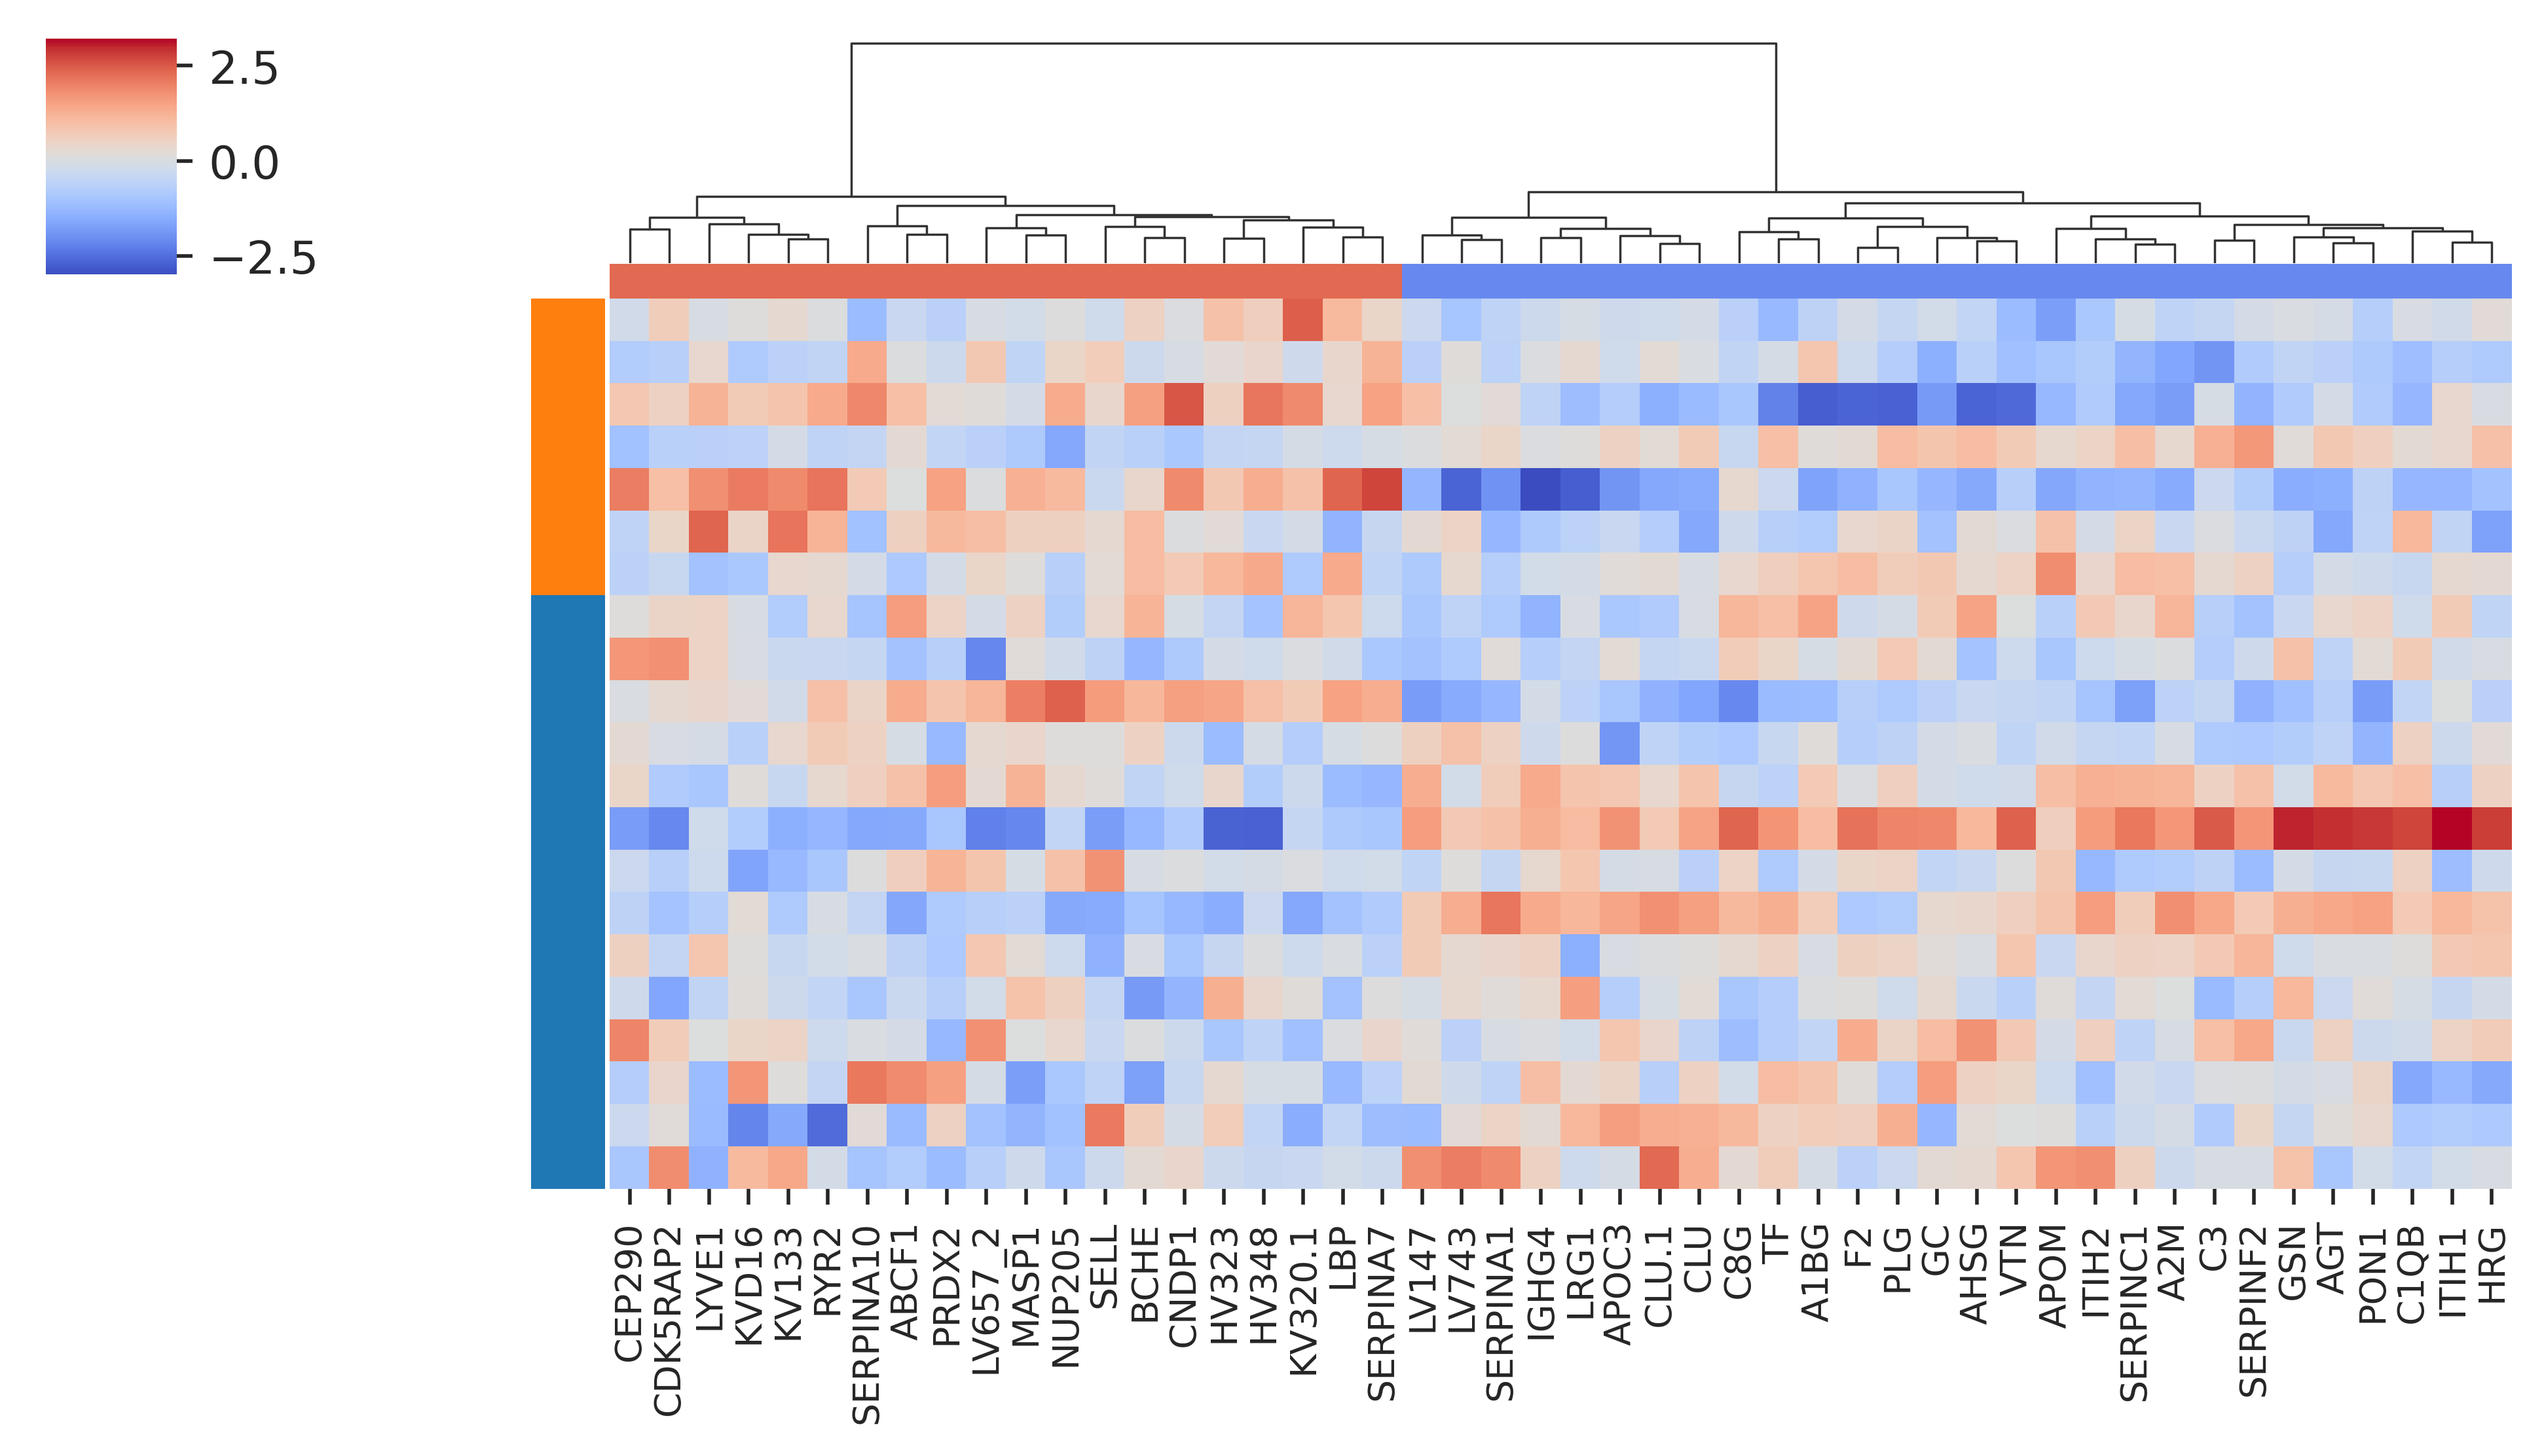

In [10]:



features_loading_reduced = pr_mwt_load.loc[:,[xc,yc]].copy()
features_loading_reduced['product'] =  features_loading_reduced[xc] *features_loading_reduced[yc]
features_loading_reduced['aproduct'] = np.abs(features_loading_reduced['product'])
qqp = features_loading_reduced['aproduct'].quantile(.75)

features_loading_reduced = features_loading_reduced.query('aproduct > @qqp').sort_values([xc])

low1 = features_loading_reduced.nsmallest(20, columns = [xc]).index.tolist()
low2 = features_loading_reduced.nsmallest(20, columns = [yc]).index.tolist()
low = list(set(low1+low2))

high1 = features_loading_reduced.nlargest(20, columns = [xc]).index.tolist()
high2 = features_loading_reduced.nlargest(20, columns = [yc]).index.tolist()
high = list(set(high1+high2))

both = list(set(low+high))

colcol = [sns.color_palette(palette='coolwarm')[-1] if x in low and not x in high1 else sns.color_palette(palette='coolwarm')[0] for x in both  ]

ts_plt = munged_blmean_data.loc[:,both  ].reset_index(level=[0,1]).copy()

data_hmp = meta_general.merge(ts_plt, on='SubjectID').copy().sort_values(['IR_IS_classification','time_index']).query("time_index >= 3")
tmin = data_hmp['time_index'].min()


clp_data = data_hmp.groupby(meta_general.columns.tolist())[both].sum().reset_index().sort_values("SSPG")

cmp = mpl.cm.RdBu_r
cmp_norm = mpl.colors.Normalize(vmin=clp_data['SSPG'].min(), vmax=clp_data['SSPG'].max())
cmp_fun = lambda x: cmp(cmp_norm(x))

rocolors = clp_data['IR_IS_classification'].copy().apply(lambda x: sns.color_palette()[0] if x == "IR" else sns.color_palette()[1]  )

clp = sns.clustermap(data = clp_data.loc[:,both], col_colors=[colcol], row_colors=[rocolors],z_score=1#, vmin = -3.5, vmax = 3.5
                     , row_cluster=False,  cmap = 'coolwarm',method='ward', xticklabels = both )

clp.ax_heatmap.tick_params(axis='both', which='both', labelsize=8)
clp.ax_heatmap.figure.set_size_inches([8,4])
clp.ax_heatmap.figure.set_dpi(500)
clp.ax_heatmap.yaxis.set_ticks([])

plt.show()

## References
<a id="1">[1]</a> 
Reza Sailani M. et al (2020). 
Deep longitudinal multiomics profiling reveals two biological seasonal patterns in California.
Nature Communications, 11(1):1-12